<a href="https://colab.research.google.com/github/AeroEng16/TennisPrediction/blob/main/dataPrepAndModelCreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import seaborn as sns
import plotly.express as px
import ast
import plotly.graph_objects as go
from dateutil.relativedelta import relativedelta
#Imports to find best matchf for player without matching name
from difflib import SequenceMatcher
from operator import itemgetter
import ast
from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  pass
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
      f.write(request.content)

from helper_functions import accuracy_fn

In [4]:

from timeit import default_timer as timer
def print_train_time(Start:float,
                     end:float,
                     device:torch.device=None):
  """ Print difference between start and end time."""
  total_time = end-Start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

## Data Loading

In [5]:
url ="https://raw.githubusercontent.com/AeroEng16/TennisPrediction/main/subsetTrainingData_140724.csv"
df = pd.read_csv(url)
columnsToDrop_notUseable =[
    'Date',
    'Court Type',
    'Tournament',
    'ScoreProgression_Sets',
    'ScoreProgression_Games',
    'RatingCalculated',
    'matchID',
    'Player1',
    'Player2',
    'Unnamed: 0',
    'matchID',
    'percentageToVictory',
    'percentageOfGamesWon',
    'dominanceRatio',
    'totalGamesPerSet',
    'Best of Sets',
    'Player1_ELO',
    'Player2_ELO'

]
columnsToDrop_notEnoughData = [
     'Player1_Aces',
 'Player1_BreakpointsWon',
 'Player1_DoubleFaults',
 'Player1_FirstServePointsWon',
 'Player1_FirstServeSuccessful',
 'Player1_MaxPointsInARow',
 'Player1_PointsWon',
 'Player1_SecondServePointsWon',
 'Player1_SecondServeSuccessful',
 'Player1_ServiceGamesWon',
 'Player1_ServicePointsLost',
 'Player1_ServicePointsWon',
 'Player1_TiebreaksWon',
 'Player1_TotalBreakpoints',
 'Player1_GamesWon',
 'Player1_MaxGamesInARow',
 'Player2_Aces',
 'Player2_BreakpointsWon',
 'Player2_DoubleFaults',
 'Player2_FirstServePointsWon',
 'Player2_FirstServeSuccessful',
 'Player2_MaxPointsInARow',
 'Player2_PointsWon',
 'Player2_SecondServePointsWon',
 'Player2_SecondServeSuccessful',
 'Player2_ServiceGamesWon',
 'Player2_ServicePointsLost',
 'Player2_ServicePointsWon',
 'Player2_TiebreaksWon',
 'Player2_TotalBreakpoints',
 'Player2_GamesWon',
 'Player2_MaxGamesInARow',

]
allColumnsToDrop = columnsToDrop_notEnoughData+columnsToDrop_notUseable
#df = unfiltered_df.drop(columnsToDrop,axis=1)
#df = unfiltered_df.drop([],axis=1)

# 1-hot encoding for playhand (1 for Right handed, 0 for left handed)
df.Player1_PlayHand = df.Player1_PlayHand.apply(lambda x: 1 if x == 'R' else 0 )
df.Player2_PlayHand = df.Player2_PlayHand.apply(lambda x: 1 if x == 'R' else 0 )

# 1-hot encoding for winner( 1 for player 1, 0 for player 2)

df.Winner = df.Winner.apply(lambda x: 1 if x == 'Player1' else 0 )


#NEED TO CCONVERT PLAYHAND AND 3 DERIVED STATS TO FLOAT
df.dominanceRatio = df.dominanceRatio.apply(ast.literal_eval)
df.percentageToVictory = df.percentageToVictory.apply(ast.literal_eval)
df.percentageOfGamesWon = df.percentageOfGamesWon.apply(ast.literal_eval)
df[['Player1DominanceRatio','Player2DominanceRatio']] = pd.DataFrame(df.dominanceRatio.tolist(), index= df.index)
df[['Player1percentageToVictory','Player2percentageToVictory']] = pd.DataFrame(df.percentageToVictory.tolist(), index= df.index)
df[['Player1percentageOfGamesWon','Player2percentageOfGamesWon']] = pd.DataFrame(df.percentageOfGamesWon.tolist(), index= df.index)

df.head()

,Unnamed: 0,Date,Tournament,Court Type,Player1,Player1_Rank,Player1_RankingPoints,Player2,Player2_Rank,Player2_RankingPoints,...,Player2_WeightKg,percentageToVictory,percentageOfGamesWon,dominanceRatio,Player1DominanceRatio,Player2DominanceRatio,Player1percentageToVictory,Player2percentageToVictory,Player1percentageOfGamesWon,Player2percentageOfGamesWon
0,0,2024-05-16,Rome,red-clay,"Hurkacz, Hubert",9,3730,"Paul, Tommy",16,2300,...,82.0,"[0.083, 0.0]","[1.0, 0.0]","[1, 0.0]",1.000,0.0,0.083,0.000,1.000,0.000
1,1,2024-05-16,Rome,red-clay,"Hurkacz, Hubert",9,3730,"Paul, Tommy",16,2300,...,82.0,"[0.083, 0.083]","[0.5, 0.5]","[1.0, 1.0]",1.000,1.0,0.083,0.083,0.500,0.500
2,2,2024-05-16,Rome,red-clay,"Hurkacz, Hubert",9,3730,"Paul, Tommy",16,2300,...,82.0,"[0.083, 0.167]","[0.333, 0.667]","[0.5, 2.0]",0.500,2.0,0.083,0.167,0.333,0.667
3,3,2024-05-16,Rome,red-clay,"Hurkacz, Hubert",9,3730,"Paul, Tommy",16,2300,...,82.0,"[0.167, 0.167]","[0.5, 0.5]","[1.0, 1.0]",1.000,1.0,0.167,0.167,0.500,0.500
4,4,2024-05-16,Rome,red-clay,"Hurkacz, Hubert",9,3730,"Paul, Tommy",16,2300,...,82.0,"[0.167, 0.25]","[0.4, 0.6]","[0.667, 1.5]",0.667,1.5,0.167,0.250,0.400,0.600


## Clean any missing data and regularize input data

In [6]:
#To begin with just drop rows with Nan values
#in sample dataset only 144 rows of 7700 missing (~1.5%, not removing significant data)
df = df.dropna()
df["EloDiff"] = df["Player1_ELO"] - df["Player2_ELO"]
df["Age_Diff"] = df["Player1_Age"] - df["Player2_Age"]


<ipython-input-6-6a58cac384ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["EloDiff"] = df["Player1_ELO"] - df["Player2_ELO"]
<ipython-input-6-6a58cac384ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Age_Diff"] = df["Player1_Age"] - df["Player2_Age"]


## Plotting Function for  Principal Component Analysis

In [7]:

import matplotlib.pyplot as plt

def plot_pca_variance(pca, width=10, dpi=120):
    """
    Plot Explained Variance and Cumulative Variance graphs for Principal Component Analysis (PCA).

    This function creates two subplots in a single figure. The first subplot displays the
    percentage of explained variance for each principal component, while the second subplot
    shows the cumulative explained variance as more components are added.

    Parameters:
    -----------
    pca : sklearn.decomposition.PCA
        The PCA object obtained from applying PCA to the data.

    width : int, optional (default=10)
        Width of the figure in inches.

    dpi : int, optional (default=120)
        Dots per inch for figure resolution.

    Returns:
    --------
    None

    Example:
    --------
    pca, X_pca, loadings = apply_pca(X, standardize=True, n_components=3)
    plot_pca_variance(pca)
    """

    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)

    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, round(10*max(evr)+0.5)/10)
    )
    axs[0].title.set_weight('bold')
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[0].set_xticks(grid)
    axs[0].set_xticklabels(grid)

    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(grid, cv, "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.01)
    )
    axs[1].title.set_weight('bold')
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[1].set_xticks(grid)
    axs[1].set_xticklabels(grid)

    # Cumulative variance value on the 2nd plot
    axs[1].annotate(f'CV={cv[-1]:.3f}', (grid[-1], cv[-1]), textcoords="offset points", xytext=(-15,-10), ha='center')

    # Set up figure
    fig.set(figwidth=width, dpi=dpi)


## Model Hyperparameters

In [8]:
BATCH_SIZE = 1

#Set epochs
EPOCHS = 200

## Prep Dataset

## Dataset Creation

In [9]:
# Create the dataset

class tennisMatchDataset(Dataset):
  def __init__(self,dataFrame,ignoredFeatures = None):

    self.df = dataFrame.drop(ignoredFeatures,axis=1)
    self.df = (self.df-self.df.min())/(self.df.max()-self.df.min())
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):

    #Extract Labels
    self.label = self.df.iloc[idx].Winner
    #convert to float
    self.label = self.label.astype(float)
    # Then convert to tensor

    self.label = torch.from_numpy(np.array(self.label)).float()

    #Extract Features
    self.features = self.df.iloc[idx].drop("Winner")
    #Convert to float
    self.features = self.features.astype(float)
    # Then convert to tensor
    self.features = torch.from_numpy(self.features.values).float()
    return self.features, self.label

In [10]:
# Percentage split for train test and validation

train_split, test_split, valid_split = 0.8,0.1,0.1

#Split by match ids not samples to give better representation

matchSamples = list(reversed(df.matchID.unique()))

#ADD SORTING FOR MATCH SAMPLES BY DATE

trainSplitIDs = matchSamples[0:int(len(matchSamples) * train_split)]
testSplitIDs = matchSamples[int(len(matchSamples) * train_split) :int(len(matchSamples) * (train_split+test_split))]
validSplitIDs = matchSamples[int(len(matchSamples) * (train_split+test_split)) :int(len(matchSamples) * (train_split+test_split+valid_split))]

len(trainSplitIDs),len(testSplitIDs),len(validSplitIDs)

train_df = df[df.matchID.isin(trainSplitIDs)]
test_df = df[df.matchID.isin(testSplitIDs)]
valid_df = df[df.matchID.isin(validSplitIDs)]

len(train_df), len(test_df), len(valid_df)

(6153, 740, 769)

In [11]:
trainingDataSet = tennisMatchDataset(dataFrame = train_df,
                                     ignoredFeatures =allColumnsToDrop)
testDataSet = tennisMatchDataset(dataFrame = test_df,
                                     ignoredFeatures =allColumnsToDrop)
validationDataSet = tennisMatchDataset(dataFrame = valid_df,
                                     ignoredFeatures =allColumnsToDrop)

In [12]:
trainDataLoader = DataLoader(trainingDataSet, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader = DataLoader(testDataSet, batch_size=BATCH_SIZE, shuffle=True)
validatinDataLoader = DataLoader(validationDataSet, batch_size=BATCH_SIZE, shuffle=True)

## Setup Model

In [13]:
# Device agnostic code

# Make device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [21]:
# Create model class
class tennisPredModel(nn.Module):
  '''
    First pass at tennis prediction model. Network design has had no real thought
  '''

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int,
               numberOfLayers: int = None):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_shape,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape),

    )
  def forward(self, x: torch.Tensor):
      return self.layer_stack(x)

In [ ]:
# Instance of model
# Set random seed
torch.manual_seed(42)

model1 = tennisPredModel(input_shape = 60,
                         hidden_units = 30,
                         output_shape = 1).to(device)

In [ ]:
def train_step(model:torch.nn.Module,
              dataLoader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              optimiser:torch.optim.Optimizer,
              accuracy_fn,
              device:torch.device = device):
  """
  Performs training step with model trying to learn on dataloader
  """

  ### Put model into training mode
  model.train()

  ### Training

  train_loss, train_acc = 0, 0

  # Add a loop to loop through the training batches

  for batch, (X,y) in enumerate(dataLoader):
    X,y = X.to(device),y.to(device)

    # 1. Forward pass (outputs raw logits from model)
    y_pred=model(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred.squeeze(),y)
    train_loss +=loss   #accumulate training loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    # 3. Zero grad
    optimiser.zero_grad()
    # 4. Loss backwards
    loss.backward()
    # 5. Optimiser step
    optimiser.step()  # Optimizer will update model parameters once per batch rather than once per epoch

  # Divide total train loss by length of train dataloader
  train_loss /=len(dataLoader)
  train_acc /= len(dataLoader)

  print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
  return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module,
              dataLoader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
  """Function to evaluate performance of trained model"""
  ## Testing

  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test,y_test in dataLoader:
      X_test,y_test=X_test.to(device),y_test.to(device)
      # 1. Forward pass
      test_pred = model(X_test)

      #2.Calcualte the loss accumulatively
      test_loss+=loss_fn(test_pred.squeeze(),y_test.squeeze())

      #3 Calculate accuracy
      test_acc += accuracy_fn(y_true=y_test,y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(dataLoader)
    # Calculate the test accuracy average per batch
    test_acc /= len(dataLoader)

  # Print out whats happening
  print(f"\nTest loss: {test_loss: .4f}, Test acc: {test_acc: .4f}")
  return test_loss, test_acc

In [ ]:

#Setup loss function and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model1.parameters(),
                            lr = 0.01,
                            )


In [ ]:
torch.manual_seed(42)
from timeit import default_timer as timer

train_time_start_on_gpu=timer()
trainAcc = []
trainLoss = []
testAcc = []
testLoss = []

# Create a optimisation and evaluation loop using train_step and test_step

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch} \n------")
  result = train_step(model=model1,
             dataLoader=trainDataLoader,
             loss_fn=loss_fn,
             optimiser = optimiser,
             accuracy_fn=accuracy_fn,
             device=device)
  trainAcc.append(result[1])
  trainLoss.append(result[0])
  result = test_step(model=model1,
            dataLoader=testDataLoader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  testAcc.append(result[1])
  testLoss.append(result[0])

  train_time_end_on_gpu=timer()

  trainingTime = print_train_time(Start=train_time_start_on_gpu,
                                  end=train_time_end_on_gpu,
                                  device=device)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 
------
Train loss: 0.6870 | Train acc: 55.40%

Test loss:  0.6985, Test acc:  51.0417
Train time on cpu: 5.521 seconds
Epoch: 1 
------


KeyboardInterrupt: 

## Train model with PCA applied first

In [14]:
#df_PCA = df.drop(allColumnsToDrop,axis=1)
df_PCA = df[["Player1DominanceRatio","Player2DominanceRatio","Player1percentageToVictory","Player2percentageToVictory","EloDiff","BreakpointsWon_ComOps","ServicePointsLost_ComOps","MaxGamesInARow_ComOps","Winner"]]


features = [x for x in df_PCA.columns if x not in ["Winner"]]

# Separating out the features
x = df_PCA.loc[:, features].values

# Separating out the target
y = df_PCA.loc[:,['Winner']].values

x = StandardScaler().fit_transform(x)

print(len(features))

8


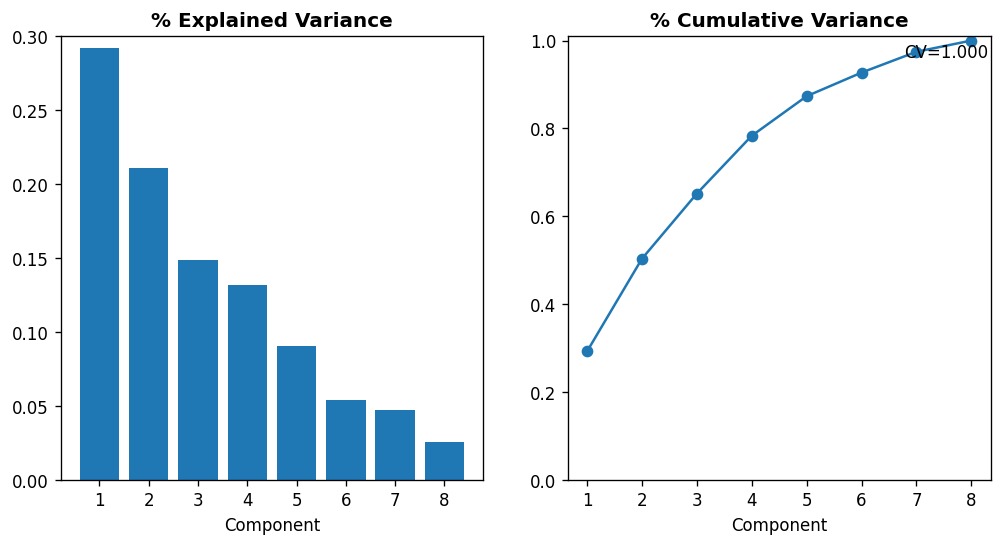

In [15]:

pca = PCA(n_components=8)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents)

finalDf = pd.concat([principalDf, df_PCA[['Winner']]], axis = 1)

finalDf = pd.concat([finalDf, df["matchID"]], axis = 1)

plot_pca_variance(pca)


In [16]:
#remove NaN's from PCA matrix
finalDf = finalDf.dropna()


In [17]:
# Create the dataset

class tennisMatchDatasetV2(Dataset):
  def __init__(self,dataFrame):

    self.df = dataFrame

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):

    #Extract Labels
    self.label = self.df.iloc[idx].Winner
    #convert to float
    self.label = self.label.astype(float)
    # Then convert to tensor

    self.label = torch.from_numpy(np.array(self.label)).float()

    #Extract Features
    self.features = self.df.iloc[idx].drop("Winner")
    #Convert to float
    self.features = self.features.astype(float)
    # Then convert to tensor
    self.features = torch.from_numpy(self.features.values).float()
    return self.features, self.label

In [18]:
# Percentage split for train test and validation

train_split, test_split, valid_split = 0.8,0.1,0.1

#Split by match ids not samples to give better representation

matchSamples = list(reversed(finalDf.matchID.unique()))

#ADD SORTING FOR MATCH SAMPLES BY DATE

trainSplitIDs = matchSamples[0:int(len(matchSamples) * train_split)]
testSplitIDs = matchSamples[int(len(matchSamples) * train_split) :int(len(matchSamples) * (train_split+test_split))]
validSplitIDs = matchSamples[int(len(matchSamples) * (train_split+test_split)) :int(len(matchSamples) * (train_split+test_split+valid_split))]

train_df_PCA = finalDf[finalDf.matchID.isin(trainSplitIDs)]
test_df_PCA = finalDf[finalDf.matchID.isin(testSplitIDs)]
valid_df_PCA = finalDf[finalDf.matchID.isin(validSplitIDs)]



In [38]:
finalDf[2].min()

-2.4033768292787845

In [19]:
trainingDataSet_PCA = tennisMatchDatasetV2(dataFrame = train_df_PCA.drop("matchID",axis=1))
testDataSet_PCA = tennisMatchDatasetV2(dataFrame = test_df_PCA.drop("matchID",axis=1))
validationDataSet_PCA = tennisMatchDatasetV2(dataFrame = valid_df_PCA.drop("matchID",axis=1))

trainDataLoader_PCA = DataLoader(trainingDataSet_PCA, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader_PCA = DataLoader(testDataSet_PCA, batch_size=BATCH_SIZE, shuffle=True)
validatinDataLoader_PCA = DataLoader(validationDataSet_PCA, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
# Instance of model
# Set random seed
torch.manual_seed(42)

model2 = tennisPredModel(input_shape = 35,
                         hidden_units = 90,
                         output_shape = 1).to(device)


#Setup loss function and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model2.parameters(),
                            lr = 0.1,
                            )

In [ ]:
torch.manual_seed(42)
from timeit import default_timer as timer

train_time_start_on_gpu=timer()
trainAcc = []
trainLoss = []
testAcc = []
testLoss = []

# Create a optimisation and evaluation loop using train_step and test_step

traindataloader_1sample = tuple(next(iter(trainDataLoader_PCA)))

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch} \n------")
  result = train_step_singleBatch(model=model2,
             #dataLoader=trainDataLoader_PCA,
             dataLoader=trainDataLoader_PCA,
             loss_fn=loss_fn,
             optimiser = optimiser,
             accuracy_fn=accuracy_fn,
             device=device)
  trainAcc.append(result[1])
  trainLoss.append(result[0])
  result = test_step(model=model2,
            dataLoader=testDataLoader_PCA,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  testAcc.append(result[1])
  testLoss.append(result[0])

  train_time_end_on_gpu=timer()

  trainingTime = print_train_time(Start=train_time_start_on_gpu,
                                  end=train_time_end_on_gpu,
                                  device=device)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 
------
Train loss: 0.5914 | Train acc: 59.38%

Test loss:  0.7268, Test acc:  49.2188
Train time on cpu: 0.587 seconds
Epoch: 1 
------
Train loss: 0.5472 | Train acc: 57.81%

Test loss:  0.6666, Test acc:  57.4219
Train time on cpu: 1.025 seconds
Epoch: 2 
------
Train loss: 0.5796 | Train acc: 62.50%

Test loss:  0.6978, Test acc:  57.4219
Train time on cpu: 1.509 seconds
Epoch: 3 
------
Train loss: 0.5525 | Train acc: 51.56%

Test loss:  0.7048, Test acc:  57.4219
Train time on cpu: 1.957 seconds
Epoch: 4 
------
Train loss: 0.7239 | Train acc: 50.00%

Test loss:  0.6675, Test acc:  57.4219
Train time on cpu: 2.428 seconds
Epoch: 5 
------
Train loss: 0.5156 | Train acc: 56.25%

Test loss:  0.7208, Test acc:  49.2188
Train time on cpu: 2.878 seconds
Epoch: 6 
------
Train loss: 0.5626 | Train acc: 59.38%

Test loss:  0.7284, Test acc:  49.2188
Train time on cpu: 3.365 seconds
Epoch: 7 
------
Train loss: 0.5533 | Train acc: 65.62%

Test loss:  0.7005, Test acc:  57.4219
T

In [23]:
# Create model class
class tennisPredModelV2(nn.Module):
  '''
    First pass at tennis prediction model. Network design has had no real thought
  '''

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int,
               numberOfLayers: int = None):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_shape,
                  out_features = hidden_units),
        nn.ReLU(),
        #nn.BatchNorm1d(hidden_units),
        nn.Linear(in_features = hidden_units,
                  out_features = hidden_units),
        nn.ReLU(),
        #nn.BatchNorm1d(hidden_units),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape),
        #nn.Dropout(),
        nn.Sigmoid()

    )
  def forward(self, x: torch.Tensor):
      return self.layer_stack(x)

In [39]:
# Instance of model
# Set random seed
torch.manual_seed(42)

model3 = tennisPredModelV2(input_shape = 8,
                         hidden_units = 200,
                         output_shape = 1).to(device)


#Setup loss function and optimiser
loss_fn = nn.BCELoss()
optimiser = torch.optim.Adam(params=model3.parameters(),
                            lr = 0.1,
                            )



In [40]:
def train_step_singleBatch(model:torch.nn.Module,
              dataLoader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              optimiser:torch.optim.Optimizer,
              accuracy_fn,
              device:torch.device = device):
  """
  Performs training step with model trying to learn on dataloader
  """

  ### Put model into training mode
  model.train()

  ### Training

  train_loss, train_acc = 0, 0

  # Add a loop to loop through the training batches

  for batch, (X,y) in enumerate(dataLoader):
    X,y = X.to(device),y.to(device)

    # 1. Forward pass (outputs raw logits from model)
    y_pred=model(X)
    #print(y_pred,y)
    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred,y.unsqueeze(1))
    train_loss +=loss   #accumulate training loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
    # 3. Zero grad
    optimiser.zero_grad()
    # 4. Loss backwards
    loss.backward()
    # 5. Optimiser step
    optimiser.step()  # Optimizer will update model parameters once per batch rather than once per epoch
    break
  # Divide total train loss by length of train dataloader
  #train_loss /=len(dataLoader)
  #train_acc /= len(dataLoader)

  print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
  return train_loss, train_acc

In [41]:
torch.manual_seed(42)
from timeit import default_timer as timer

train_time_start_on_gpu=timer()
trainAcc = []
trainLoss = []
testAcc = []
testLoss = []

# Create a optimisation and evaluation loop using train_step and test_step


for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch} \n------")
  result = train_step_singleBatch(model=model3,
             dataLoader=trainDataLoader_PCA,
             loss_fn=loss_fn,
             optimiser = optimiser,
             accuracy_fn=accuracy_fn,
             device=device)
  trainAcc.append(result[1])
  trainLoss.append(result[0])
  result = test_step(model=model3,
            dataLoader=testDataLoader_PCA,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)
  testAcc.append(result[1])
  testLoss.append(result[0])

  train_time_end_on_gpu=timer()

  trainingTime = print_train_time(Start=train_time_start_on_gpu,
                                  end=train_time_end_on_gpu,
                                  device=device)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 
------
Train loss: 0.6817 | Train acc: 0.00%

Test loss:  25.5456, Test acc:  53.6170
Train time on cpu: 0.985 seconds
Epoch: 1 
------
Train loss: 100.0000 | Train acc: 100.00%

Test loss:  53.6170, Test acc:  53.6170
Train time on cpu: 1.930 seconds
Epoch: 2 
------
Train loss: 100.0000 | Train acc: 100.00%

Test loss:  53.6170, Test acc:  53.6170
Train time on cpu: 2.928 seconds
Epoch: 3 
------
Train loss: 0.0000 | Train acc: 0.00%

Test loss:  53.6170, Test acc:  53.6170
Train time on cpu: 3.921 seconds
Epoch: 4 
------
Train loss: 0.0000 | Train acc: 0.00%

Test loss:  53.6170, Test acc:  53.6170
Train time on cpu: 4.627 seconds
Epoch: 5 
------
Train loss: 0.0000 | Train acc: 0.00%

Test loss:  53.6170, Test acc:  53.6170
Train time on cpu: 5.329 seconds
Epoch: 6 
------
Train loss: 0.0000 | Train acc: 0.00%

Test loss:  53.6170, Test acc:  53.6170
Train time on cpu: 6.033 seconds
Epoch: 7 
------
Train loss: 100.0000 | Train acc: 100.00%

Test loss:  53.6170, Test acc

KeyboardInterrupt: 

In [33]:
losses_np = np.array([x.item() for x in trainLoss])

In [34]:
fig = px.line(y=losses_np)
fig.show()